Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.

Задача: https://www.kaggle.com/competitions/icecube-neutrinos-in-deep-ice/overview

Цель - предсказать направление нейтрино на основе данных детектора IceCube.

Решение: нейронная сеть с архитектурой CNN (Convolutional Neural Network - сверточная нейронная сеть, данная архитектура была рассмотрена на уроках)

In [1]:
import os
import warnings
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import gc
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow')
import tensorflow as tf
from tqdm import tqdm

def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    return np.average(np.abs(np.arccos(scalar_prod)))

def convert_to_cartesian(azimuth, zenith):
    x = np.sin(zenith) * np.cos(azimuth)
    y = np.sin(zenith) * np.sin(azimuth)
    z = np.cos(zenith)
    return x, y, z

def convert_to_polar(x, y, z):
    r = math.sqrt(x * x + y * y + z * z)
    c = -1 if y < 0 else 1
    azimuth = math.acos(x / math.sqrt(x * x + y * y)) * c
    zenith = math.acos(z / r)
    return azimuth, zenith

def adjust_polar(azimuth, zenith):
    if azimuth < 0:
        azimuth += math.pi * 2
    elif zenith < 0:
        zenith += math.pi
    return azimuth, zenith

In [2]:
sensors_df = pd.read_csv('/media/dmitriy/Disk/Downloads/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')
x_min, x_max, y_min, y_max, z_min, z_max = sensors_df.x.min(), sensors_df.x.max(), sensors_df.y.min(), sensors_df.y.max(), sensors_df.z.min(), sensors_df.z.max()
sensors_df['x'] = (sensors_df['x'] - x_min) / (x_max - x_min)
sensors_df['y'] = (sensors_df['y'] - y_min) / (y_max - y_min)
sensors_df['z'] = (sensors_df['z'] - z_min) / (z_max - z_min)
meta_df = pd.read_parquet('/media/dmitriy/Disk/Downloads/icecube-neutrinos-in-deep-ice/train_meta.parquet')
meta_df[['batch_id', 'event_id', 'first_pulse_index', 'last_pulse_index']] = meta_df[['batch_id', 'event_id', 'first_pulse_index', 'last_pulse_index']].astype(int)
meta_df[['azimuth', 'zenith']] = meta_df[['azimuth', 'zenith']].astype(np.float32)

df = pd.read_parquet('/media/dmitriy/Disk/Downloads/icecube-neutrinos-in-deep-ice/train/batch_1.parquet')
df['auxiliary'] = df['auxiliary'].astype(int)

In [3]:
sample_size = 5000

meta_batch_df = meta_df[meta_df.batch_id == 1]
meta_batch_df[['target_x', 'target_y', 'target_z']] = meta_batch_df[['azimuth', 'zenith']].apply(lambda x: convert_to_cartesian(x[0], x[1]), axis=1, result_type='expand')

matrix_main = np.zeros((sample_size, 5160, 6), dtype=np.float32)
# matrix_main = np.zeros((sample_size, 4600, 6), dtype=np.float32)
target = np.zeros((sample_size, 3))

for indx in tqdm(range(0, sample_size, 1)):
    _, event_id, first_pulse_index, last_pulse_index, azimuth, zenith, target_x, target_y, target_z = meta_batch_df.iloc[indx].values
    df_study = df.iloc[int(first_pulse_index):int(last_pulse_index)].merge(sensors_df, on='sensor_id')
    minimum_time = df_study['time'].min()
    period = df_study['time'].max() - minimum_time
    df_study['time'] = (df_study['time'] - minimum_time) / (period)
    df_study.set_index('sensor_id', inplace=True)
    matrix = np.zeros((5160, 6))
    # matrix = np.zeros((4600, 6))
    matrix[df_study.index.values, :] = df_study.values

    matrix_main[indx, :, :] = matrix
    target[indx, :] = target_x, target_y, target_z

del df, meta_df, sensors_df, meta_batch_df, df_study
gc.collect()

100%|██████████| 5000/5000 [00:17<00:00, 293.61it/s]


0

In [4]:
train_p, validation_p = 0.92, 0.05

matrix_train = matrix_main[:int(sample_size * train_p), :, :]
target_train = target[:int(sample_size * train_p), :]

matrix_validation = matrix_main[int(sample_size * train_p):int(sample_size * (train_p + validation_p)), :, :]
target_validation = target[int(sample_size * train_p):int(sample_size * (train_p + validation_p)), :]

matrix_test = matrix_main[int(sample_size * (train_p + validation_p)):, :, :]
target_test = target[int(sample_size * (train_p + validation_p)):, :]

matrix_train.shape, target_train.shape, matrix_validation.shape, target_validation.shape, matrix_test.shape, target_test.shape

((4600, 5160, 6),
 (4600, 3),
 (250, 5160, 6),
 (250, 3),
 (150, 5160, 6),
 (150, 3))

In [5]:
tf.keras.backend.clear_session()

In [6]:
gpu_device = tf.config.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu_device, True)

In [7]:
with tf.device('/GPU:0'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (516, 6), activation='relu', input_shape=(5160, 6, 1)),
        tf.keras.layers.MaxPooling2D((2, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='linear')
    ])


model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [8]:
model.fit(matrix_train, target_train, epochs=10, batch_size=32, validation_data=(matrix_validation, target_validation), callbacks=[early_stopping])

Epoch 1/10
144/144 [==============================] - 33s 179ms/step - loss: 0.3524 - mae: 0.5067 - val_loss: 0.3329 - val_mae: 0.4961
Epoch 2/10
144/144 [==============================] - 23s 161ms/step - loss: 0.3329 - mae: 0.4989 - val_loss: 0.3330 - val_mae: 0.4966
Epoch 3/10
144/144 [==============================] - 23s 162ms/step - loss: 0.3330 - mae: 0.4989 - val_loss: 0.3329 - val_mae: 0.4962
Epoch 4/10
144/144 [==============================] - 24s 164ms/step - loss: 0.3329 - mae: 0.4989 - val_loss: 0.3329 - val_mae: 0.4961


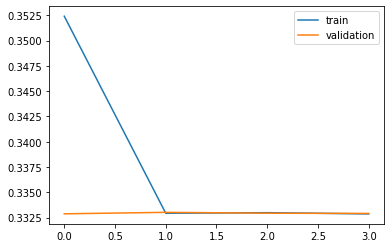

In [9]:
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [10]:
pred = model.predict(matrix_test)
pred_polar = np.array([convert_to_polar(x, y, z) for x, y, z in pred])
target_test_polar = np.array([convert_to_polar(x, y, z) for x, y, z in target_test])

az_true, zen_true = target_test_polar[:, 0], target_test_polar[:, 1]
az_pred, zen_pred = pred_polar[:, 0], pred_polar[:, 1]

5/5 [==============================] - 1s 162ms/step


In [11]:
angular_dist_score(az_true, zen_true, az_pred, zen_pred)

1.5098055681811036

В улучшении работы нейронной сети помогло добавление скрытого слоя, а также увеличение параметра sample_size при формировании обучающего датасета.